In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import xarray as xr
import contextily as ctx
import shapely
import pint_xarray

In [2]:
# Beaver Creek  Snotel
# <POINT Z (-120.99 48.528 4310)>

# Thunder Basin Snotel
# <POINT Z (-121.256 48.879 3630)>

# Thunder Creek USGS
# POINT Z (-121.07290 48.67263 1220.00000)

# Beaver Creek USGS
# POINT Z (-121.07343 48.77759 1610.23000)
THUNDER_BASIN_SNOTEL = ('990:WA:SNTL', 'Thunder Basin Snotel Site')
BEAVER_CREEK_SNOTEL = ('817:WA:SNTL', 'Beaver Creek Snotel Site')

beaver_creek_snotel_point = shapely.geometry.Point(-120.99, 48.528, 4310)
thunder_basin_snotel_point = shapely.geometry.Point(-121.256, 48.879, 3630)
thunder_creek_usgs_point = shapely.geometry.Point(-121.07290, 48.67263, 1220.00000)
beaver_creek_usgs_point = shapely.geometry.Point(-121.07343, 48.77759, 1610.23000)
snotel_points = [beaver_creek_snotel_point, thunder_basin_snotel_point]
usgs_points = [beaver_creek_usgs_point, thunder_creek_usgs_point]
snotel_points = shapely.multipoints(snotel_points)
usgs_points = shapely.multipoints(usgs_points)

In [3]:
snotel_daily = xr.open_dataset('../../data/snotel/snotel_daily_1980_2024.zarr')
usgs_daily = xr.open_dataset('../../data/stream/usgs_daily_1980_2024.zarr')

/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


In [4]:
# Beaver/Thunder in that order
usgs_df = gpd.GeoDataFrame({'site': ['12172000', '12175500'], 'site_name': ['Beaver Creek', 'Thunder Creek'], 'geometry': usgs_points.geoms} )
# Extract coordinates from the geometry column
usgs_df['lat'] = usgs_df.geometry.apply(lambda geom: geom.y)
usgs_df['lon'] = usgs_df.geometry.apply(lambda geom: geom.x)
usgs_df['elevation_ft'] = usgs_df.geometry.apply(lambda geom: geom.z)

usgs_daily = usgs_daily.assign_coords(
    lat=('site', usgs_df['lat'].values),
    lon=('site', usgs_df['lon'].values),
    elevation_ft=('site', usgs_df['elevation_ft'].values),
    site_name=('site', usgs_df['site_name'].values)
)

usgs_daily['site_name'] = usgs_daily.site_name.astype(str)
usgs_daily['site'] = usgs_daily.site.astype(str)
usgs_daily


<xarray.Dataset> Size: 386kB
Dimensions:       (date: 16072, site: 2)
Coordinates:
  * site          (site) <U8 64B '12172000' '12175500'
  * date          (date) datetime64[ns] 129kB 1980-01-01 ... 2024-01-01
    lat           (site) float64 16B 48.78 48.67
    lon           (site) float64 16B -121.1 -121.1
    elevation_ft  (site) float64 16B 1.61e+03 1.22e+03
    site_name     (site) <U13 104B 'Beaver Creek' 'Thunder Creek'
Data variables:
    DISCHARGE     (date, site) float64 257kB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    Daily

In [5]:
# Extract and embed geometry coordinates in  Xarray
# Beaver/Thunder in that order
snotel_df = gpd.GeoDataFrame({'site': ['817:WA:SNTL', '990:WA:SNTL'], 'site_name': ['Beaver Creek', 'Thunder Basin'], 'geometry': snotel_points.geoms} )
# Extract coordinates from the geometry column
snotel_df['lat'] = snotel_df.geometry.apply(lambda geom: geom.y)
snotel_df['lon'] = snotel_df.geometry.apply(lambda geom: geom.x)
snotel_df['elevation_ft'] = snotel_df.geometry.apply(lambda geom: geom.z)

snotel_daily = snotel_daily.assign_coords(
    lat=('site', snotel_df['lat'].values),
    lon=('site', snotel_df['lon'].values),
    elevation_ft=('site', snotel_df['elevation_ft'].values),
    site_name=('site', snotel_df['site_name'].values)
)

snotel_daily['site_name'] = snotel_daily.site_name.astype(str)
snotel_daily['site'] = snotel_daily.site.astype(str)
snotel_daily

<xarray.Dataset> Size: 2MB
Dimensions:                    (date: 13140, site: 2)
Coordinates:
  * date                       (date) datetime64[ns] 105kB 1987-10-20T08:00:0...
  * site                       (site) <U11 88B '817:WA:SNTL' '990:WA:SNTL'
    lat                        (site) float64 16B 48.53 48.88
    lon                        (site) float64 16B -121.0 -121.3
    elevation_ft               (site) float64 16B 4.31e+03 3.63e+03
    site_name                  (site) <U13 104B 'Beaver Creek' 'Thunder Basin'
Data variables:
    MIN AIR TEMP               (date, site) float64 210kB ...
    MAX AIR TEMP               (date, site) float64 210kB ...
    ACCUMULATED PRECIPITATION  (date, site) float64 210kB ...
    AVG AIR TEMP               (date, site) float64 210kB ...
    SWE                        (date, site) float64 210kB ...
    AIR TEMP                   (date, site) float64 210kB ...
    SNOWDEPTH                  (date, site) float64 210kB ...
    PRECIPITATION              (date, site) float64 210kB ...
Attributes:
    Description:  Snotel Data
    Date Range:   1980-2024
    Sites:        Thunder Basin, Beaver Creek
    Frequency:    Daily

In [6]:
usgs_daily.date

<xarray.DataArray 'date' (date: 16072)> Size: 129kB
array(['1980-01-01T00:00:00.000000000', '1980-01-02T00:00:00.000000000',
       '1980-01-03T00:00:00.000000000', ..., '2023-12-30T00:00:00.000000000',
       '2023-12-31T00:00:00.000000000', '2024-01-01T00:00:00.000000000'],
      shape=(16072,), dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 129kB 1980-01-01 1980-01-02 ... 2024-01-01

In [7]:
snotel_daily.date

<xarray.DataArray 'date' (date: 13140)> Size: 105kB
array(['1987-10-20T08:00:00.000000000', '1987-10-21T08:00:00.000000000',
       '1987-10-22T08:00:00.000000000', ..., '2023-12-30T08:00:00.000000000',
       '2023-12-31T08:00:00.000000000', '2024-01-01T08:00:00.000000000'],
      shape=(13140,), dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 105kB 1987-10-20T08:00:00 ... 2024-01-01T0...

In [8]:
snotel_daily_updated = snotel_daily.reindex(date=pd.date_range('1980-01-01', '2024-01-01', freq='D'), method='nearest',tolerance=np.timedelta64(12, 'h'))

In [9]:
snotel_daily_updated.to_zarr('../../data/snotel/snotel_daily_backfilled_1980_2024.zarr', mode='w')
usgs_daily.to_zarr('../../data/stream/usgs_daily_backfilled_1980_2024.zarr', mode='w')

/var/folders/28/n2khkrt15537q1z3stgtj5200000gn/T/ipykernel_48839/3640423700.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1987-10-20T08:00:00'. Serializing with units 'hours since 1987-10-20T08:00:00' instead. Set encoding['dtype'] to floating point dtype to serialize with units 'days since 1987-10-20T08:00:00'. Set encoding['units'] to 'hours since 1987-10-20T08:00:00' to silence this warning .
  snotel_daily_updated.to_zarr('../../data/snotel/snotel_daily_backfilled_1980_2024.zarr', mode='w')
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/core/array.py:3991: UserWarnin

In [10]:
snotel_hourly = xr.open_dataset('../../data/snotel/snotel_hourly_1980_2024.zarr')
usgs_hourly = xr.open_dataset('../../data/stream/usgs_instantaneous_1980_2024.zarr')

# Beaver/Thunder in that order
usgs_df = gpd.GeoDataFrame({'site': ['12172000', '12175500'], 'site_name': ['Beaver Creek', 'Thunder Creek'], 'geometry': usgs_points.geoms} )
# Extract coordinates from the geometry column
usgs_df['lat'] = usgs_df.geometry.apply(lambda geom: geom.y)
usgs_df['lon'] = usgs_df.geometry.apply(lambda geom: geom.x)
usgs_df['elevation_ft'] = usgs_df.geometry.apply(lambda geom: geom.z)

usgs_hourly = usgs_hourly.assign_coords(
    lat=('site', usgs_df['lat'].values),
    lon=('site', usgs_df['lon'].values),
    elevation_ft=('site', usgs_df['elevation_ft'].values),
    site_name=('site', usgs_df['site_name'].values)
)

usgs_hourly['site_name'] = usgs_hourly.site_name.astype(str)
usgs_hourly['site'] = usgs_hourly.site.astype(str)
usgs_hourly


/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 27MB
Dimensions:       (date: 1134647, site: 2)
Coordinates:
  * date          (date) datetime64[ns] 9MB 1989-10-01T07:15:00 ... 2024-01-0...
  * site          (site) <U8 64B '12172000' '12175500'
    lat           (site) float64 16B 48.78 48.67
    lon           (site) float64 16B -121.1 -121.1
    elevation_ft  (site) float64 16B 1.61e+03 1.22e+03
    site_name     (site) <U13 104B 'Beaver Creek' 'Thunder Creek'
Data variables:
    DISCHARGE     (date, site) float64 18MB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [11]:
# Extract and embed geometry coordinates in  Xarray
# Beaver/Thunder in that order
snotel_df = gpd.GeoDataFrame({'site': ['817:WA:SNTL', '990:WA:SNTL'], 'site_name': ['Beaver Creek', 'Thunder Basin'], 'geometry': snotel_points.geoms} )
# Extract coordinates from the geometry column
snotel_df['lat'] = snotel_df.geometry.apply(lambda geom: geom.y)
snotel_df['lon'] = snotel_df.geometry.apply(lambda geom: geom.x)
snotel_df['elevation_ft'] = snotel_df.geometry.apply(lambda geom: geom.z)

snotel_hourly = snotel_hourly.assign_coords(
    lat=('site', snotel_df['lat'].values),
    lon=('site', snotel_df['lon'].values),
    elevation_ft=('site', snotel_df['elevation_ft'].values),
    site_name=('site', snotel_df['site_name'].values)
)

snotel_hourly['site_name'] = snotel_hourly.site_name.astype(str)
snotel_hourly['site'] = snotel_hourly.site.astype(str)
snotel_hourly

<xarray.Dataset> Size: 16MB
Dimensions:                    (date: 218948, site: 2)
Coordinates:
  * date                       (date) datetime64[ns] 2MB 1987-10-22T06:00:00 ...
  * site                       (site) <U11 88B '817:WA:SNTL' '990:WA:SNTL'
    lat                        (site) float64 16B 48.53 48.88
    lon                        (site) float64 16B -121.0 -121.3
    elevation_ft               (site) float64 16B 4.31e+03 3.63e+03
    site_name                  (site) <U13 104B 'Beaver Creek' 'Thunder Basin'
Data variables:
    ACCUMULATED PRECIPITATION  (date, site) float64 4MB ...
    SWE                        (date, site) float64 4MB ...
    AIR TEMP                   (date, site) float64 4MB ...
    SNOWDEPTH                  (date, site) float64 4MB ...
Attributes:
    Description:  Snotel Data
    Date Range:   1980-2024
    Sites:        Thunder Basin, Beaver Creek
    Frequency:    Hourly

In [12]:
snotel_hourly_updated = snotel_hourly.reindex_like(usgs_hourly.date, method='bfill',tolerance=np.timedelta64(1, 'h'))
# snotel_hourly.reindex(date=pd.date_range('1989-10-01T07:15:00.000000000', '2024-01-02T07:45:00.000000000', freq='15 min'), method='nearest',tolerance=np.timedelta64(1, 'h'))

In [ ]:
snotel_hourly_updated.to_zarr('../../data/snotel/snotel_hourly_backfill_1980_2024.zarr', mode='w')
usgs_hourly.to_zarr('../../data/stream/usgs_instantaneous_backfill_1980_2024.zarr', mode='w')

/var/folders/28/n2khkrt15537q1z3stgtj5200000gn/T/ipykernel_24154/3491027336.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'hours since 1987-10-22T06:00:00'. Serializing with units 'minutes since 1987-10-22T06:00:00' instead. Set encoding['dtype'] to floating point dtype to serialize with units 'hours since 1987-10-22T06:00:00'. Set encoding['units'] to 'minutes since 1987-10-22T06:00:00' to silence this warning .
  snotel_hourly_updated.to_zarr('../../data/snotel/snotel_hourly_1980_2024.zarr', mode='w')
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/Users/jesse/projects/FlakesAndFlows/.pixi/envs/default/lib/python3.12/site-packages/zarr/core/array.py:3991: UserWarning: 

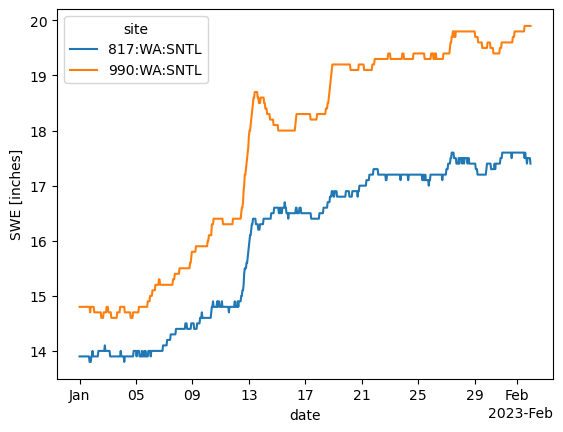

In [ ]:
usgs_winter_2023 = usgs_hourly.sel(date=slice('2023-01-01', '2023-01-02'))
usgs_winter_2023.DISCHARGE.plot.line(x='date', hue='site')
snotel_winter_2023 = snotel_hourly.sel(date=slice('2023-01-01', '2023-02-01'))
snotel_winter_2023.SWE.plot.line(x='date', hue='site')